In [82]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models, utils
import numpy as np
import os
import random
from PIL import Image
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import ConcatDataset


In [54]:
datamap = {0: 'pen', 
          1: 'book',
          2: 'candy',
          3: 'oreal', 
          4: '梳子', 
          5: 'fork',
          6: 'glass',
          7: '大梳子',
          8: '发卡',
          9: 'keyboard',
          10: 'knife',
          11: 'lipstick',
          12: 'handcream',
          13: 'mouse',
          14: 'cup',
          15: 'plate',
          16: 'shampoo', 
          17: 'soap',
          18: '锅铲',
          19: 'spoon', 
          20: 'toothbrush', 
          21: 'toothpaste'}


In [287]:
train_transform = transforms.Compose([transforms.Resize((112, 224)),
                                      transforms.ToTensor()])
hflip_transform = transforms.Compose([transforms.Resize((112, 224)),
                                     transforms.RandomHorizontalFlip(1),
                                      transforms.ToTensor()])
vflip_transform = transforms.Compose([transforms.Resize((112, 224)),
                                     transforms.RandomVerticalFlip(1),
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((112, 224)),
                                     transforms.ToTensor()])

In [288]:
test_data = datasets.ImageFolder('./5_shot/test', transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

input_data = ConcatDataset(
    [datasets.ImageFolder('./5_shot/train', transform=train_transform),
    datasets.ImageFolder('./5_shot/train', transform=hflip_transform),
    datasets.ImageFolder('./5_shot/train', transform=vflip_transform)]
)

train_idx, valid_idx= train_test_split(
    np.arange(len(input_data)), test_size=0.2, random_state=42, shuffle=True)


train_data = torch.utils.data.Subset(input_data, train_idx)
val_data = torch.utils.data.Subset(input_data, valid_idx)
image_datasets = {
    'train': 
    torch.utils.data.Subset(input_data, train_idx),
    'validation': 
    torch.utils.data.Subset(input_data, valid_idx)
}


dataloaders = {
    'train':
    torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True),

    'validation':
    torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=True)
}

train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=True)

In [255]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

tensor([12, 19, 13, 18,  2, 14, 17, 13, 20, 21, 10,  2, 20, 20, 14, 17])


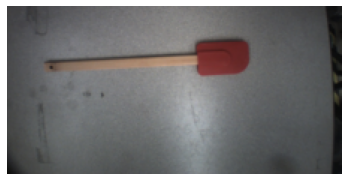

In [289]:
# Run this to test your data loader
images, labels = next(iter(train_loader))
# helper.imshow(images[0], normalize=False)
imshow(images[3], normalize=False)
print(labels)

In [290]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet50(pretrained=True).to(device)
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 512),
               nn.ReLU(inplace=True),
                nn.Linear(512, 128),
                nn.ReLU(inplace=True),
               nn.Linear(128, 22)).to(device)

In [291]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [292]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
#                 print(f'labels: {labels}')

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
#                 print(f'preds: {preds}')
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [293]:
model_trained3 = train_model(model, criterion, optimizer, num_epochs=20)


Epoch 1/20
----------
train loss: 3.0375, acc: 0.1288
validation loss: 2.9563, acc: 0.2121
Epoch 2/20
----------
train loss: 2.4054, acc: 0.3939
validation loss: 2.2186, acc: 0.5909
Epoch 3/20
----------
train loss: 1.6818, acc: 0.6894
validation loss: 1.4325, acc: 0.6364
Epoch 4/20
----------
train loss: 1.0676, acc: 0.7841
validation loss: 0.7734, acc: 0.9394
Epoch 5/20
----------
train loss: 0.6572, acc: 0.8864
validation loss: 0.7535, acc: 0.8333
Epoch 6/20
----------
train loss: 0.4737, acc: 0.8750
validation loss: 0.3286, acc: 0.9697
Epoch 7/20
----------
train loss: 0.2703, acc: 0.9621
validation loss: 0.3043, acc: 0.9697
Epoch 8/20
----------
train loss: 0.3230, acc: 0.9129
validation loss: 0.2624, acc: 0.9394
Epoch 9/20
----------
train loss: 0.3139, acc: 0.9242
validation loss: 0.2584, acc: 0.9394
Epoch 10/20
----------
train loss: 0.2044, acc: 0.9621
validation loss: 0.1135, acc: 0.9697
Epoch 11/20
----------
train loss: 0.0830, acc: 1.0000
validation loss: 0.1567, acc: 0.98

In [300]:
preds = []
for images, _ in test_loader:
    outputs = model_trained3(images)
    _, predicted = torch.max(outputs, 1)
    preds += predicted.tolist()
preds

[0,
 0,
 0,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 13,
 9,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 3,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 21,
 21,
 16,
 21,
 3,
 2,
 2,
 2,
 21,
 21,
 21,
 2,
 3,
 2,
 3,
 1,
 3,
 2,
 3,
 3,
 2,
 3,
 21,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 3,
 21,
 12,
 4,
 18,
 4,
 4,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 4,
 4,
 4,
 8,
 4,
 4,
 4,
 8,
 5,
 3,
 10,
 4,
 4,
 5,
 5,
 8,
 8,
 19,
 8,
 5,
 19,
 8,
 19,
 19,
 19,
 5,
 8,
 5,
 5,
 19,
 19,
 6,
 6,
 14,
 6,
 6,
 7,
 16,
 6,
 6,
 7,
 6,
 14,
 14,
 7,
 7,
 6,
 6,
 6,
 8,
 7,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 13,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 13,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 13,
 10,


In [299]:
items = []
for i in range(len(preds)):
    items.append(datamap[preds[i]])


In [274]:
import pandas as pd
test_preds = pd.DataFrame(list(zip(list(range(len(preds))),preds)), columns=['id', 'category'])
test_preds.to_csv('20747601Liu.csv')